```{figure} ../images/qvp.png
:width: 100%
:align: center
:name: qvp
Ryzhkov et al. (2016) QVP

# Perfiles Cuasi-Verticales (Quasi-Vertical Profiles)


---

## 🧭 Introducción

En este cuadernillo exploraremos el uso de **Perfiles Cuasi-Verticales (QVPs)** como una técnica eficiente para analizar la estructura vertical de la atmósfera utilizando datos de radar meteorológico polarimétrico. Mostraremos cómo generar y visualizar QVPs a partir de datos almacenados en formato Zarr mediante el flujo de trabajo **ARCO**, y compararemos su eficiencia frente al enfoque tradicional basado en archivos binarios.

## 📚 Descripción general

✔ Qué es un Perfil Cuasi-Vertical (QVP) y su utilidad en radar meteorológico polarimétrico  
✔ Cómo acceder a datos de radar preprocesados en formato Zarr con ARCO  
✔ Cómo calcular QVPs para distintas variables radar  
✔ Cómo comparar el flujo de trabajo ARCO con un enfoque tradicional basado en archivos binarios  
✔ Visualización de perfiles verticales de reflectividad, reflectividad diferencial, correlación cruzada y fase diferencial



## ✅ Requisitos Previos
```{list-table}
:header-rows: 1
* - Concepto
  - Importancia
  - Enlace sugerido
* - [Fundamentos de Python](../1.fundamentos/1.1.Fundamentos-python.ipynb)
  - Necesario
  - Fundamentos del lenguaje y estructuras básicas
* - [Xarray](../1.fundamentos/1.4.Introduccion-Xarray.ipynb)
  - Necesario
  - Manipulación de arreglos y datos multidimensionales
* - [Radar meteorológico](../1.fundamentos/1.5.Introduccion-Radar.ipynb)
  - Necesario
  - Conceptos básicos de adquisición y estructura de datos de radar
* - [Zarr y flujos de trabajo FAIR](https://zarr.dev/)
  - Útil
  - Concepto de almacenamiento en la nube y acceso eficiente a grandes volúmenes de datos
* - [Artículo sobre QVPs](https://doi.org/10.1175/JTECH-D-15-0020.1)
  - Útil
  - Fundamento teórico sobre Perfiles Cuasi-Verticales (Ryzhkov et al., 2016)


- **Tiempo de ejecución estimado:** 5-10 minutos
- **Requisitos computacionales:**
  - RAM mínima: 4 GB
  - Conexión a internet estable (para acceso a datos Zarr en la nube)
  - Compatible con Binder y entornos locales

---

## Librerías

Importamos las librerías necesarias para este cuaderno:


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xradar
import fsspec
import gzip
import tempfile
import os

import matplotlib.pyplot as plt
import cmweather

from dask.distributed import Client, LocalCluster


## 1. 📡 ¿Qué es un Perfil Cuasi-Vertical (QVP)?

Los **Perfiles Cuasi-Verticales** (_Quasi-Vertical Profiles_, QVPs) constituyen una **técnica** utilizada en el análisis de datos de radar meteorológico polarimétrico. Esta técnica consiste en **promediar la información de una elevación del radar (típicamente 20°) a lo largo de todos los azimuts** **para** generar un perfil vertical simplificado, que permite representar la estructura vertical de la atmósfera en las cercanías del radar como se observa en la siguiente [figura](#fig-qvp)


```{figure} https://journals.ametsoc.org/view/journals/atot/33/3/images/full-jtech-d-15-0020_1-f2.jpg
:width: 50%
:align: center
:name: fig-qvp
Esquema conceptual de un perfil cuasi-vertical (QVP), donde se promedia azimutalmente una elevación específica del radar para construir un perfil vertical.  
Fuente: [Ryzhkov et al., 2016](https://doi.org/10.1175/JTECH-D-15-0020.1)



Los QVPs resultan útiles para:

- Estudiar la **evolución microfísica** de tormentas (como el crecimiento de cristales de hielo o procesos de fusión de hidrometeoros),
- Monitorear la **fase de precipitación**,
- Evaluar **transiciones entre fases líquidas y sólidas** en sistemas de precipitación.


In [2]:
from dask.distributed import Client, LocalCluster

# Create a local cluster with correct arguments
cluster = LocalCluster(
    n_workers=4,              # Number of worker processes
    memory_limit='2GB'        # Per worker memory limit
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36973/status,
Dashboard: http://127.0.0.1:36973/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36703,Workers: 0
Dashboard: http://127.0.0.1:36973/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33011,Total threads: 3
Dashboard: http://127.0.0.1:42781/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:39853,


## 2. 🗂️ Acceso a datos ARCO en formato Zarr

En esta sección accederemos a un conjunto de datos de radar meteorológico preprocesado, almacenado en formato **Zarr v3** en un bucket público mantenido por el proyecto **Pythia**.

Los datos corresponden al radar **KVNX (Vance AFB, Oklahoma)** para el evento del **20 de mayo de 2011**, y están disponibles gracias a la iniciativa **ARCO-FAIR**. Estos datos se encuentran almacenados de manera eficiente en la nube (Jetstream 2), lo que permite el acceso distribuido y escalable sin necesidad de descarga previa.


In [3]:
import xarray as xr
import xradar
import fsspec

# Ruta al archivo Zarr en la nube
url = "https://js2.jetstream-cloud.org:8001/"
path = "s3://pythia/radar/AtmosCol2025/KVNX.zarr"

# Abrimos nuestro dataset 
dtree = xr.open_datatree(
    path,
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "anon": True,
            "client_kwargs": {
                "endpoint_url": url
            }
        }
    }
)

In [4]:
display(dtree)

<xarray.DataTree>
Group: /
└── Group: /VCP-12
    │   Dimensions:        (vcp_time: 40)
    │   Coordinates:
    │     * vcp_time       (vcp_time) datetime64[ns] 320B 2011-05-20T09:27:09 ... 201...
    │   Data variables:
    │       longitude      (vcp_time) float32 160B dask.array<chunksize=(1,), meta=np.ndarray>
    │       altitude       (vcp_time) float64 320B dask.array<chunksize=(1,), meta=np.ndarray>
    │       latitude       (vcp_time) float32 160B dask.array<chunksize=(1,), meta=np.ndarray>
    │       volume_number  (vcp_time) float64 320B dask.array<chunksize=(1,), meta=np.ndarray>
    │   Attributes:
    │       Conventions:      None
    │       instrument_name:  KVNX
    │       version:          None
    │       title:            None
    │       institution:      None
    │       references:       None
    │       source:           None
    │       history:          None
    │       comment:          im/exported using xradar
    │       scan_name:        VCP-12
    ├── Group: /VCP-12/georeferencing_correction
    │       Dimensions:    ()
    │       Coordinates:
    │           altitude   int64 8B ...
    │           latitude   float64 8B ...
    │           longitude  float64 8B ...
    ├── Group: /VCP-12/sweep_14
    │       Dimensions:            (vcp_time: 40, azimuth: 360, range: 460)
    │       Coordinates:
    │         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    │         * range              (range) float32 2kB 2.125e+03 2.375e+03 ... 1.169e+05
    │           altitude           int64 8B ...
    │           crs_wkt            int64 8B ...
    │           elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    │           latitude           float64 8B ...
    │           longitude          float64 8B ...
    │           time               (azimuth) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    │           x                  (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
    │           z                  (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
    │           y                  (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
    │       Data variables:
    │           DBZH               (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           WRADH              (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           VRADH              (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           PHIDP              (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           ZDR                (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           RHOHV              (vcp_time, azimuth, range) float32 26MB dask.array<chunksize=(1, 360, 460), meta=np.ndarray>
    │           sweep_number       (vcp_time) float64 320B dask.array<chunksize=(1,), meta=np.ndarray>
    │           sweep_fixed_angle  (vcp_time) float32 160B dask.array<chunksize=(1,), meta=np.ndarray>
    ├── Group: /VCP-12/sweep_13
    │       Dimensions:            (vcp_time: 40, azimuth: 360, range: 500)
    │       Coordinates:
    │         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    │         * range              (range) float32 2kB 2.125e+03 2.375e+03 ... 1.269e+05
    │           altitude           int64 8B ...
    │           crs_wkt            int64 8B ...
    │           elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    │           latitude           float64 8B ...
    │           longitude          float64 8B ...
    │           time               (azimuth) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.nda

In [5]:
print(f"Tamaño del conjunto de datos es: {dtree.nbytes / 1024**3: .2f} GB")

Tamaño del conjunto de datos es:  6.99 GB


```{note}
Este dataset se encuentra almacenado en el bucket:  
`s3://pythia/radar/AtmosCol2025/KVNX.zarr`  
y se accede a través del servicio Jetstream 2 de la Universidad de Indiana, compatible con la interfaz S3.

## 2.1 🗂️ Exploración del DataTree

Una vez cargado el dataset en formato `DataTree`, podemos inspeccionar su estructura jerárquica. Esta estructura refleja la organización típica de un archivo de radar con múltiples elevaciones (*sweeps*), metadatos globales y parámetros del radar.

Podemos listar los nodos hijos principales del árbol de datos:



In [6]:
list(dtree.children)

['VCP-12']

Luego podemos explorar los niveles inferiores, por ejemplo:

In [7]:
# Exploramos los hijos del volumen VCP-12
list(dtree["VCP-12"].children)

['georeferencing_correction',
 'sweep_14',
 'sweep_13',
 'sweep_15',
 'sweep_16',
 'sweep_2',
 'sweep_1',
 'sweep_3',
 'sweep_4',
 'sweep_11',
 'radar_parameters',
 'sweep_0',
 'sweep_10',
 'sweep_5',
 'sweep_12',
 'sweep_6',
 'sweep_8',
 'sweep_7',
 'sweep_9']

Cada `sweep_N` representa un barrido del radar a un ángulo de elevación distinto. Además, encontramos nodos como `radar_parameters` y `georeferencing_correction`.

:::{note}
La nomenclatura `sweep_0`, `sweep_1`, ..., `sweep_16` representa los diferentes ángulos de elevación en el volumen de escaneo. El número más alto generalmente corresponde a los ángulos más altos, ideales para QVPs.
:::

También es posible inspeccionar directamente una variable meteorológica, como la reflectividad horizontal (`DBZH`) en un sweep específico:


### 2.2 📁 Acceso a nodos con sintaxis de ruta (`file-path syntax`)

Una ventaja del uso de `xarray-datatree` es que permite acceder a cualquier nodo o variable utilizando rutas tipo archivo, lo que simplifica el manejo jerárquico de los datos.

Seleccionaremos la variable `DBZH` desde el nodo correspondiente utilizando la sintaxis tipo archivo:


In [8]:
# Forma recomendada
dbzh = dtree["/VCP-12/sweep_16/DBZH"]

In [9]:
display(dbzh)

<xarray.DataArray 'DBZH' (vcp_time: 40, azimuth: 360, range: 460)> Size: 26MB
dask.array<open_dataset-DBZH, shape=(40, 360, 460), dtype=float32, chunksize=(1, 360, 460), chunktype=numpy.ndarray>
Coordinates:
  * vcp_time   (vcp_time) datetime64[ns] 320B 2011-05-20T09:27:09 ... 2011-05...
  * azimuth    (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range      (range) float32 2kB 2.125e+03 2.375e+03 ... 1.166e+05 1.169e+05
    altitude   int64 8B ...
    elevation  (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    crs_wkt    int64 8B ...
    latitude   float64 8B ...
    longitude  float64 8B ...
    time       (azimuth) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    y          (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
    x          (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
    z          (azimuth, range) float64 1MB dask.array<chunksize=(180, 230), meta=np.ndarray>
Attributes:
    long_name:      Equivalent reflectivity factor H
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h

:::{hint}
También es posible acceder a la misma variable usando:

```python
dtree["VCP-12"]["sweep_16"].DBZH
dtree["VCP-12"]["sweep_16"]["DBZH"]

## 3. ⚙️ Cálculo de Perfiles Cuasi-Verticales (QVPs)

Una vez explorada la estructura de datos, procedemos a calcular los Perfiles Cuasi-Verticales (QVPs). Este tipo de perfil se genera promediando una variable de radar a lo largo de todos los azimuts en un barrido de elevación fijo, lo que proporciona una vista simplificada pero útil de la estructura vertical de la atmósfera.

### 3.1. 📥 Selección del sweep y del período de interés

Trabajaremos con el `sweep_16`, correspondiente a un ángulo de elevación bajo, adecuado para QVPs. Además, seleccionamos un intervalo de tiempo entre **10:00 y 12:00 UTC del 20 de mayo de 2011**, con el objetivo de reproducir los resultados presentados en **Ryzhkov et al. (2016)**, quienes analizaron un sistema convectivo de mesoescala (MCS) observado con el radar KVNX en esa misma fecha.



In [10]:
ds_qvp = dtree["/VCP-12/sweep_16"].ds.sel(
    vcp_time=slice("2011-05-20 10:00", "2011-05-20 12:00")
)

:::{note}
Según Ryzhkov et al. (2016), el evento del 20 de mayo de 2011 fue un MCS observado en el norte de Oklahoma por el radar KVNX.
:::

### 3.2 🧮 Función para calcular un QVP

Una vez seleccionados los datos del barrido adecuado, definimos una función que calcule el Perfil Cuasi-Vertical (QVP) a partir de cualquier variable radar que siga el esquema tridimensional típico (`vcp_time`, `azimuth`, `range`).

La función realiza el promedio azimutal y, si la variable está en escala logarítmica (como `dBZ`), realiza la conversión a escala lineal antes del promedio y luego la convierte nuevamente a logarítmica. También transforma la dimensión `range` a `height` (en km) usando el ángulo de elevación medio.


In [11]:
import numpy as np


def compute_qvp(ds: xr.Dataset, var="DBZH") -> xr.DataArray:
    """
    Calcula un QVP (Perfil Cuasi-Vertical) para una variable específica del radar.

    Parámetros:
    ----------
    ds : xr.Dataset
        Dataset que contiene la variable radar.
    var : str
        Nombre de la variable a procesar (ej. 'DBZH', 'ZDR', 'RHOHV', 'PHIDP').

    Retorna:
    --------
    xr.DataArray
        QVP con coordenadas [vcp_time, height] y atributos preservados.
    """
    units = ds[var].attrs.get("units", "")

    # Conversión de logarítmico a lineal si es necesario
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth", skipna=True)
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var].mean("azimuth", skipna=True)

    # Conversión de distancia a altura estimada (en km)
    elev_rad = ds.sweep_fixed_angle.mean(skipna=True).values * np.pi / 180.0
    qvp = qvp.assign_coords({
        "range": (qvp.range.values * np.sin(elev_rad)) / 1000  # convierte a km
    })

    qvp = qvp.rename(f"qvp_{var}")
    qvp = qvp.rename({"range": "height"})
    return qvp

:::{tip}
Esta función es reutilizable para múltiples variables polarimétricas (DBZH, ZDR, RHOHV, PHIDP). Asegúrate de que la variable tenga dimensiones azimuth y range, y que el atributo units esté definido correctamente.
:::

:::{warning}
Si el atributo units no está definido o no comienza con "dB", se asumirá que la variable está en escala lineal. Revisa los metadatos antes de aplicar la función.
:::

### 3.3 🔄 Cálculo de QVPs para múltiples variables

Una vez definida la función `compute_qvp()`, procedemos a aplicarla a las principales variables polarimétricas del radar: `DBZH`, `ZDR`, `RHOHV` y `PHIDP`.

Estas variables ofrecen información complementaria sobre la estructura microfísica de la atmósfera:

- `DBZH`: Reflectividad horizontal, relacionada con la intensidad de la precipitación.
- `ZDR`: Reflectividad diferencial, útil para distinguir tipos de hidrometeoros.
- `RHOHV`: Coeficiente de correlación cruzada, indica homogeneidad de las partículas.
- `PHIDP`: Fase diferencial, relacionada con el contenido de agua líquida.


In [12]:
%%time
qvp_ref = compute_qvp(ds_qvp, var="DBZH").compute()
qvp_zdr = compute_qvp(ds_qvp, var="ZDR").compute()
qvp_rhohv = compute_qvp(ds_qvp, var="RHOHV").compute()
qvp_phidp = compute_qvp(ds_qvp, var="PHIDP").compute()

CPU times: user 506 ms, sys: 57.9 ms, total: 564 ms
Wall time: 3.58 s


:::{note}
Usamos .compute() para forzar la ejecución de los cálculos en memoria. Esto es necesario porque los objetos cargados con xarray y Dask son evaluados de forma perezosa (lazy evaluation).
:::

## 📈 4. Visualización de Perfiles Cuasi-Verticales (QVPs)

### 4.1. 🖼️ Función para graficar QVPs en panel 2×2

Definimos una función para visualizar los Perfiles Cuasi-Verticales (QVPs) de las variables más comunes en radar polarimétrico. Esto facilita la comparación entre distintos métodos (Zarr vs binario) o eventos meteorológicos.


In [13]:
import matplotlib.pyplot as plt
import cmweather


def plot_qvp_panels(qvp_ref, qvp_zdr, qvp_rhohv, qvp_phidp):
    """
    Visualiza perfiles cuasi-verticales (QVPs) en un panel 2x2 con formato científico completo.

    Parámetros:
    -----------
    qvp_ref : xr.DataArray
        Reflectividad (DBZH)
    qvp_zdr : xr.DataArray
        Reflectividad diferencial (ZDR)
    qvp_rhohv : xr.DataArray
        Coeficiente de correlación cruzada (RHOHV)
    qvp_phidp : xr.DataArray
        Fase diferencial (PHIDP)
    title : str
        Título de la figura
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

    # Panel 1: Reflectividad (DBZH)
    cf = qvp_ref.plot.contourf(
        x="vcp_time", y="height", cmap="ChaseSpectral",
        levels=np.arange(-10, 55, 1), ax=axs[0][0], add_colorbar=False
    )
    contour = qvp_ref.plot.contour(
        x="vcp_time", y="height", levels=np.arange(-10, 50, 10),
        colors="k", ax=axs[0][0]
    )
    axs[0][0].clabel(contour, fmt="%d", inline=True, fontsize=8)
    axs[0][0].set_title(r"$Z$")
    axs[0][0].set_ylabel(r"$Height \ [km]$")
    axs[0][0].set_ylim(0, 7)
    plt.colorbar(cf, ax=axs[0][0], label=r"$Reflectivity \ [dBZ]$")

    # Panel 2: Reflectividad diferencial (ZDR)
    cf1 = qvp_zdr.plot.contourf(
        x="vcp_time", y="height", cmap="ChaseSpectral",
        levels=np.linspace(-1, 5, 11), ax=axs[0][1], add_colorbar=False
    )
    contour = qvp_ref.plot.contour(
        x="vcp_time", y="height", levels=np.arange(-10, 50, 10),
        colors="k", ax=axs[0][1]
    )
    axs[0][1].clabel(contour, fmt="%d", inline=True, fontsize=8)
    axs[0][1].set_title(r"$Z_{DR}$")
    axs[0][1].set_ylabel("")
    axs[0][1].set_xlabel("")
    plt.colorbar(cf1, ax=axs[0][1], label=r"$Diff. \ Reflectivity \ [dB]$")

    # Panel 3: RHOHV
    cf2 = qvp_rhohv.plot.contourf(
        x="vcp_time", y="height", cmap="Carbone11",
        levels=np.arange(0.8, 1.01, 0.01), ax=axs[1][0], add_colorbar=False
    )
    contour = qvp_ref.plot.contour(
        x="vcp_time", y="height", levels=np.arange(-10, 50, 10),
        colors="k", ax=axs[1][0]
    )
    axs[1][0].clabel(contour, fmt="%d", inline=True, fontsize=8)
    axs[1][0].set_title(r"$\rho _{HV}$")
    axs[1][0].set_ylabel(r"$Height \ [km]$")
    axs[1][0].set_xlabel(r"$Time \ [UTC]$")
    plt.colorbar(cf2, ax=axs[1][0], label=r"$Cross-Correlation \ Coef.$")

    # Panel 4: PHIDP
    cf3 = qvp_phidp.plot.contourf(
        x="vcp_time", y="height", cmap="PD17",
        levels=np.arange(0, 110, 5), ax=axs[1][1], add_colorbar=False
    )
    contour = qvp_ref.plot.contour(
        x="vcp_time", y="height", levels=np.arange(-10, 50, 10),
        colors="k", ax=axs[1][1]
    )
    axs[1][1].clabel(contour, fmt="%d", inline=True, fontsize=8)
    axs[1][1].set_title(r"$\theta _{DP}$")
    axs[1][1].set_xlabel(r"$Time \ [UTC]$")
    axs[1][1].set_ylabel("")
    plt.colorbar(cf3, ax=axs[1][1], label=r"$Differential \ Phase \ [deg]$")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 4.2 📊 Visualización de QVPs usando función reutilizable

Ahora utilizamos la función `plot_qvp_panels()` para graficar los Perfiles Cuasi-Verticales (QVPs) de las variables `DBZH`, `ZDR`, `RHOHV` y `PHIDP`, obtenidos a partir de los datos del radar KVNX para el evento del 20 de mayo de 2011.


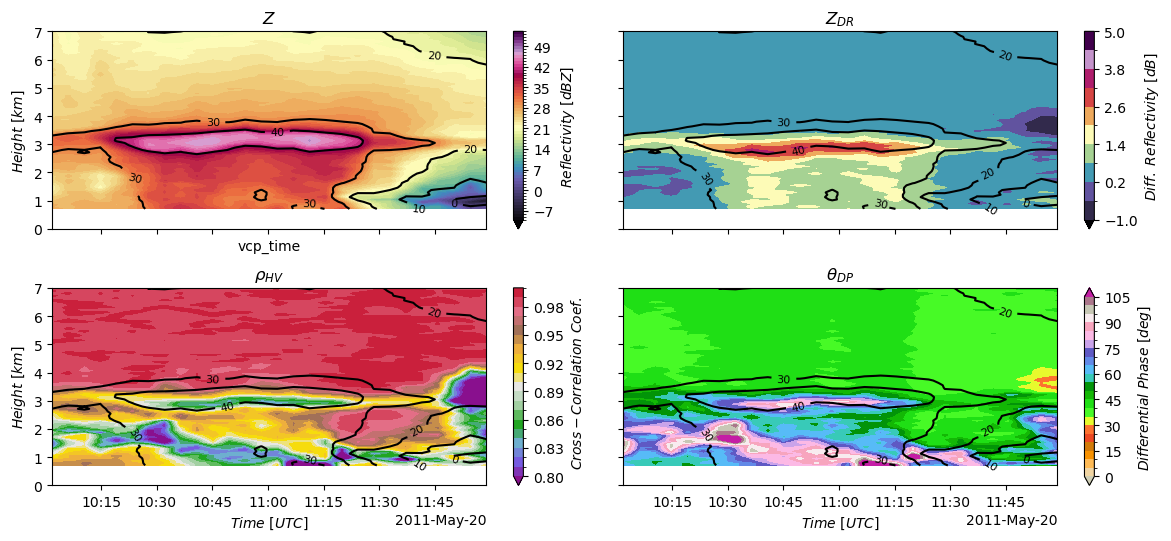

CPU times: user 1.27 s, sys: 81.2 ms, total: 1.35 s
Wall time: 1.29 s


In [14]:
%%time
plot_qvp_panels(
    qvp_ref=qvp_ref,
    qvp_zdr=qvp_zdr,
    qvp_rhohv=qvp_rhohv,
    qvp_phidp=qvp_phidp,
)

El flujo completo —desde el acceso a datos remotos hasta el cálculo y visualización de los QVPs— se realiza de forma muy eficiente gracias al formato Zarr y la compatibilidad con lectura directa vía `fsspec`.

- **Cálculo de QVPs:** ~11.9 segundos
- **Visualización completa (panel 2×2):** ~1.4 segundos

:::{admonition} ⏱️ Tiempo total aproximado
**13.3 segundos** para acceder, procesar y visualizar datos tridimensionales de radar polarimétrico directamente desde almacenamiento en la nube.
:::

:::{note}
Esta eficiencia es posible gracias al uso del formato **FAIR-compliant Zarr v3**, procesamiento lazy con **Dask**, y el acceso remoto vía **fsspec** sin necesidad de descarga local.
:::

:::{note}
Cada archivo descargado contiene un volumen escaneado completo. Al concatenar los sweep_16, reconstruimos una secuencia temporal continua entre 10:00 y 12:00 UTC.
:::

:::{warning}
Este proceso secuencial puede tardar más de 1 minuto debido a la descarga, descompresión y apertura de múltiples archivos binarios.
:::

## 📝 Conclusiones

En este cuaderno comparamos dos enfoques para el cálculo de Perfiles Cuasi-Verticales (QVPs) a partir de datos de radar polarimétrico:

1. 🌀 **Flujo tradicional** usando archivos binarios NEXRAD (`.gz`)
2. 🧊 **Flujo moderno FAIR** usando datos preprocesados en formato Zarr (ARCO)

La siguiente tabla resume los tiempos aproximados y la aceleración lograda en cada etapa:

```{list-table}
:header-rows: 1
* - Etapa
  - ARCO-Zarr
  - Binario NEXRAD
  - Aceleración (×)
* - Acceso / lectura de datos
  - ~0 s (lazy loading)
  - ~140 s
  - ~140×
* - Cálculo de QVPs
  - ~11.9 s
  - ~1.6 s
  - 0.13×
* - Visualización
  - ~1.4 s
  - ~1.4 s
  - = 
* - **Total estimado**
  - **~13.3 s**
  - **~143.0 s**
  - **~10.7×**


:::{admonition} 🏆 Ventajas del enfoque ARCO-Zarr

- Acceso remoto eficiente con fsspec (sin necesidad de descarga)
- Formato FAIR: Findable, Accessible, Interoperable, Reusable
- Procesamiento lazy optimizado con Dask
- Reproducibilidad garantizada gracias al preprocesamiento estandarizado
:::

:::{warning}
El flujo tradicional requiere múltiples pasos manuales (descarga, descompresión, limpieza de archivos temporales) y duplica los datos localmente, lo que lo vuelve menos escalable y más propenso a errores.
:::

:::{tip}
Para aplicaciones educativas, colaborativas o en la nube, el enfoque FAIR con datos Zarr es altamente recomendable por su eficiencia, portabilidad y facilidad de uso.
:::

## 🔜 ¿Qué sigue?

En este cuaderno aprendiste a calcular y visualizar Perfiles Cuasi-Verticales (QVPs) utilizando datos de radar en formato Zarr. Te recomendamos explorar:

- **[Estimación Cuantitativa de Precipitación (QPE)](3.5.QPE.ipynb):** Aprende a estimar tasas de precipitación a partir de datos de radar polarimétrico.
- **[Datos de reanálisis ERA5](3.3.ERA5.ipynb):** Complementa el análisis de radar con datos de reanálisis atmosférico.
- **[Artículo científico sobre QVPs](https://doi.org/10.1175/JTECH-D-15-0020.1):** Lee el paper original de Ryzhkov et al. (2016) sobre la técnica QVP.

También puedes experimentar con:
- Aplicar QVPs a otros eventos meteorológicos disponibles en el bucket de Jetstream2
- Combinar QVPs con análisis de trayectorias atmosféricas
- Automatizar el monitoreo continuo de QVPs para vigilancia operacional


## 📖 Referencias y recursos

**Publicaciones científicas:**
- Ryzhkov, A. V., Zhang, P., Reeves, H., Kumjian, M., Tschallener, T., Trömel, S., & Simmer, C. (2016). Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. *Journal of Atmospheric and Oceanic Technology*, 33(3), 551–562. [https://doi.org/10.1175/JTECH-D-15-0020.1](https://doi.org/10.1175/JTECH-D-15-0020.1)

**Herramientas y datos:**
- [xradar Documentation](https://docs.openradarscience.org/projects/xradar/)
- [Zarr Format Specification](https://zarr.dev/)
- [Project Pythia Radar Cookbook](https://projectpythia.org/radar-cookbook/)
- [NOAA NEXRAD Archive (AWS)](https://registry.opendata.aws/noaa-nexrad/)
- [Jetstream2 Cloud Infrastructure](https://jetstream-cloud.org/)

**Datasets utilizados:**
- Radar KVNX (Vance AFB, Oklahoma) - 20 de mayo de 2011
- Fuente ARCO-Zarr: `s3://pythia/radar/AtmosCol2025/KVNX.zarr`
- Fuente NEXRAD binario: `s3://noaa-nexrad-level2/`
